# Quantum pipeline using JAX backend

This performs an exact classical simulation.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 120
SEED = 0

### Read in the data and create diagrams

In [13]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')
print(test_labels)

[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]


### Create diagrams

In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)
print(type(raw_train_diagrams))

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


<class 'list'>


### Remove the cups

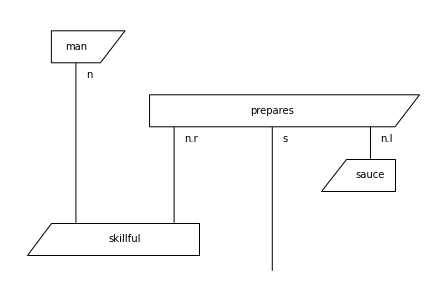

In [5]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

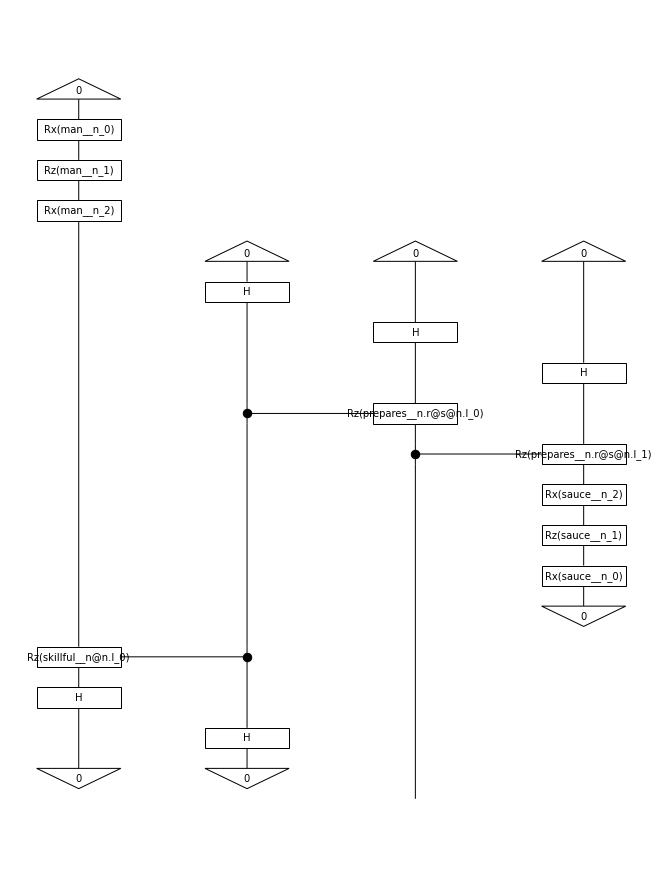

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

### Parameterise

In [7]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

### Define evaluation metric

In [8]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [9]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [11]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 1.0450   valid/loss: 0.8951   train/acc: 0.4714   valid/acc: 0.4333
Epoch 12:   train/loss: 0.6771   valid/loss: 0.6604   train/acc: 0.7000   valid/acc: 0.7333
Epoch 24:   train/loss: 0.3903   valid/loss: 0.3722   train/acc: 0.8857   valid/acc: 0.8667
Epoch 36:   train/loss: 0.2611   valid/loss: 0.2645   train/acc: 0.9429   valid/acc: 0.9333
Epoch 48:   train/loss: 0.2420   valid/loss: 0.2703   train/acc: 0.9571   valid/acc: 0.9333
Epoch 60:   train/loss: 0.2243   valid/loss: 0.2646   train/acc: 0.9571   valid/acc: 0.9333
Epoch 72:   train/loss: 0.1771   valid/loss: 0.1742   train/acc: 0.9714   valid/acc: 0.9667
Epoch 84:   train/loss: 0.1689   valid/loss: 0.1531   train/acc: 0.9857   valid/acc: 0.9333
Epoch 96:   train/loss: 0.1597   valid/loss: 0.1514   train/acc: 0.9857   valid/acc: 0.9333
Epoch 108:  train/loss: 0.1520   valid/loss: 0.1407   train/acc: 0.9857   valid/acc: 0.9333
Epoch 120:  train/loss: 0.1491   valid/loss: 0.1493   train/acc: 0.9714   valid/

### Show results

Test accuracy: 1.0


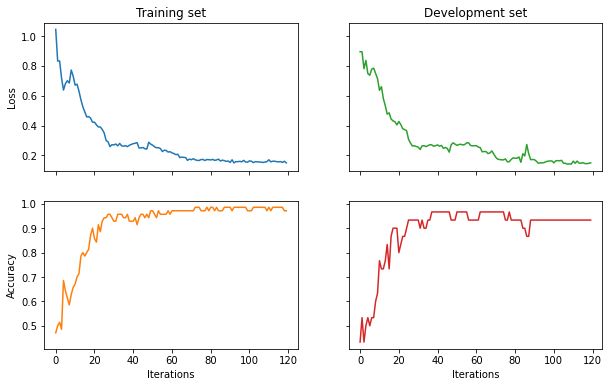

In [12]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)